In [1]:
# Toy EBM for 1‑step time-series forecasting (noisy sine).
# This code trains a tiny energy model using a contrastive (softmax/NCE-style) loss.
# It then demonstrates two simple inference methods:
#  - re-ranking: propose many candidate next-values and pick lowest-energy ones
#  - SGLD sampling: Langevin dynamics in y-space using gradients of the energy
#
# Run time is kept small (single CPU).

import math
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)
np.random.seed(0)

In [2]:
# --- 1) make a tiny dataset: random sine patches with noise ---
class SineNextDataset(Dataset):
    def __init__(self, n_samples=2000, context_len=20):
        self.context_len = context_len
        self.n = n_samples
        self.contexts = []
        self.nexts = []
        for i in range(n_samples):
            amp = np.random.uniform(0.9, 1.1)
            freq = np.random.uniform(0.9, 1.2)
            phase = np.random.uniform(0, math.pi/2)
            t = np.arange(context_len + 1)
            series = amp * np.sin(freq * t + phase)
            series += np.random.normal(scale=0.05, size=series.shape)  # observation noise
            ctx = series[:-1].astype(np.float32)
            nxt = series[-1].astype(np.float32)
            self.contexts.append(ctx)
            self.nexts.append(nxt)
        self.contexts = np.stack(self.contexts)
        self.nexts = np.stack(self.nexts)

    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        return self.contexts[idx], self.nexts[idx]

In [11]:
dataset = SineNextDataset(n_samples=2000, context_len=20)
loader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=True)

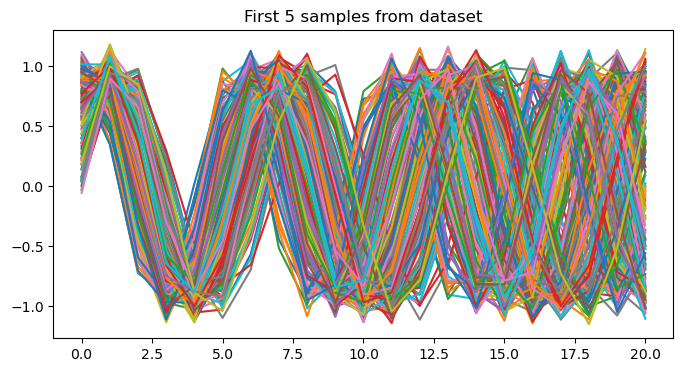

In [12]:
plt.figure(figsize=(8,4))
for i in range(200):
    context, nxt = dataset[i]
    x_axis = np.arange(len(context) + 1)
    series = np.concatenate([context, [nxt]])
    plt.plot(x_axis, series, label=f"sample {i}")
plt.title("First 5 samples from dataset")
plt.show()

In [13]:
# --- 2) tiny energy network: concatenates context and candidate y and outputs scalar energy ---
class EnergyNet(nn.Module):
    def __init__(self, context_len=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(context_len + 1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, context, y):
        # context: (B, C), y: (B,) or (B,1)
        if y.dim() == 1:
            y = y.unsqueeze(1)
        inp = torch.cat([context, y], dim=1)
        return self.net(inp).squeeze(1)  # (B,)

In [14]:
 device = torch.device("cuda")
model = EnergyNet(context_len=20).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
K = 10  # negatives per example
neg_std = 0.6
loss_fn = nn.CrossEntropyLoss()

n_epochs = 100
print_every = 5

In [15]:
for contexts_np, pos_np in loader:
    context_sample = contexts_np
    pos_sample = pos_np
    break

In [19]:
contexts = context_sample.to(device)
pos = pos_sample.to(device)

In [20]:
B = contexts.size(0)
B

1

In [25]:
neg = pos.unsqueeze(1) + torch.randn(B, K, device=device) * neg_std

In [29]:
pos_e = model(contexts, pos)

In [35]:
contexts_rep = contexts.unsqueeze(1).expand(-1, K, -1).reshape(B*K, -1)

In [38]:
neg_flat = neg.reshape(B*K)

In [42]:
neg_e_flat = model(contexts_rep, neg_flat)

In [45]:
neg_e = neg_e_flat.view(B, K)       

In [53]:
logits = torch.cat([(-pos_e).unsqueeze(1), (-neg_e)], dim=1)

In [55]:
targets = torch.zeros(B, dtype=torch.long, device=device)

In [58]:
loss = loss_fn(logits, targets)

In [38]:
# --- 3) training loop: contrastive (softmax) loss over 1 positive + K negatives ---
for epoch in range(1, n_epochs+1):
    running = 0.0
    for contexts_np, pos_np in loader:
        contexts = contexts_np.to(device)
        pos = pos_np.to(device)
        B = contexts.size(0)
        # generate K negatives per positive (hard negatives by perturbing the true y)
        neg = pos.unsqueeze(1) + torch.randn(B, K, device=device) * neg_std  # (B, K)
        # compute energies
        pos_e = model(contexts, pos)                     # (B,)
        # flatten negatives to evaluate in batch
        contexts_rep = contexts.unsqueeze(1).expand(-1, K, -1).reshape(B*K, -1)  # (B*K, C)
        neg_flat = neg.reshape(B*K)
        neg_e_flat = model(contexts_rep, neg_flat)       # (B*K,)
        neg_e = neg_e_flat.view(B, K)                    # (B, K)
        # logits: convert energies to unnormalized log-probabilities by using -E
        logits = torch.cat([(-pos_e).unsqueeze(1), (-neg_e)], dim=1)  # (B, K+1)
        targets = torch.zeros(B, dtype=torch.long, device=device)     # positive is index 0
        loss = loss_fn(logits, targets)
        opt.zero_grad(); loss.backward(); opt.step()
        running += float(loss.detach().cpu().item()) * B
    if epoch % print_every == 0 or epoch == 1:
        print(f"epoch {epoch:3d}   loss {running / len(dataset):.4f}")

epoch   1   loss 2.2962
epoch   5   loss 2.0441
epoch  10   loss 1.3076
epoch  15   loss 1.0382
epoch  20   loss 0.9538
epoch  25   loss 0.9257
epoch  30   loss 0.8878
epoch  35   loss 0.8881
epoch  40   loss 0.8712
epoch  45   loss 0.8721
epoch  50   loss 0.8590
epoch  55   loss 0.8560
epoch  60   loss 0.8696
epoch  65   loss 0.8590
epoch  70   loss 0.8230
epoch  75   loss 0.8278
epoch  80   loss 0.8285
epoch  85   loss 0.8575
epoch  90   loss 0.8333
epoch  95   loss 0.8506
epoch 100   loss 0.8380



Example: true next = -0.41110703349113464


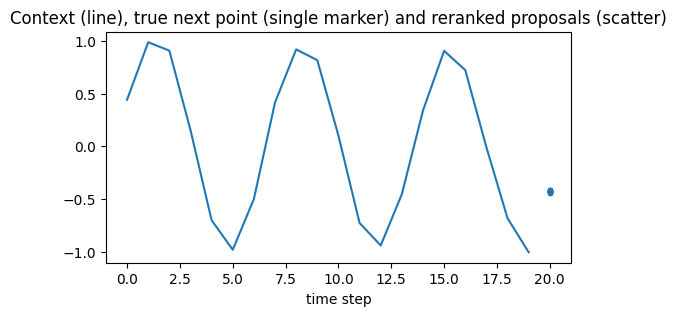

In [39]:
# --- 4) inference: pick a random context from dataset and show predictions ---
example_idx = np.random.randint(len(dataset))
ctx_np, true_next = dataset[example_idx]
context = torch.tensor(ctx_np, dtype=torch.float32, device=device).unsqueeze(0)  # (1, C)
print("\nExample: true next =", float(true_next))

# 4a) reranking: propose many candidates and choose lowest-energy ones
n_proposals = 3000
proposals = torch.randn(n_proposals, device=device) * 1.0 + float(ctx_np[-1])  # centered at last observed value
# evaluate energy for each proposal (expand context to match)
ctx_rep = context.expand(n_proposals, -1)  # (n_proposals, C)
with torch.no_grad():
    energies_prop = model(ctx_rep, proposals)  # (n_proposals,)
# take top-k lowest energy proposals
k_show = 30
best_idx = torch.topk(-energies_prop, k_show).indices  # top by -energy = lowest energy
best_vals = proposals[best_idx].cpu().numpy()

# Plot 1: context and reranked candidates (shown at t = context_len)
plt.figure(figsize=(6,3))
x_ctx = np.arange(len(ctx_np))
plt.plot(x_ctx, ctx_np)  # context time series
# extend with the true next value to show ground truth
plt.plot([len(ctx_np)], [true_next])  # this will use default style
plt.scatter([len(ctx_np)] * len(best_vals), best_vals, s=8)  # proposed predictions
plt.title("Context (line), true next point (single marker) and reranked proposals (scatter)")
plt.xlabel("time step")
plt.show()

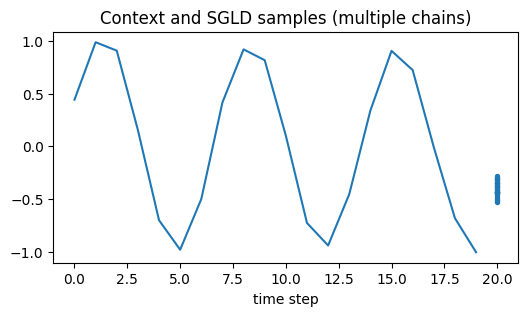

In [40]:
# 4b) SGLD sampling in y-space (gradient-based sampling)
n_chains = 30
y = torch.randn(n_chains, device=device) * 1.0 + float(ctx_np[-1])  # init near last value
y = y.detach().requires_grad_(True)
sgld_steps = 150
sgld_lr = 2e-3
for t in range(sgld_steps):
    E = model(context.expand(n_chains, -1), y)   # (n_chains,)
    grads = torch.autograd.grad(E.sum(), y)[0]
    noise = torch.randn_like(y)
    y = y - sgld_lr * grads + (2*sgld_lr)**0.5 * noise
    y = y.detach().requires_grad_(True)
samples_sgld = y.detach().cpu().numpy()

# Plot 2: context and SGLD samples at t=context_len
plt.figure(figsize=(6,3))
plt.plot(x_ctx, ctx_np)
plt.plot([len(ctx_np)], [true_next])
plt.scatter([len(ctx_np)] * len(samples_sgld), samples_sgld, s=8)
plt.title("Context and SGLD samples (multiple chains)")
plt.xlabel("time step")
plt.show()